In [1]:
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
import alphashape
from scipy.spatial import KDTree
import random
from shapely.geometry import Polygon
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors

In [2]:
# Step 1: Load the crown data using Dask
df = dd.read_csv("crown_points.txt", delimiter=" ", names=["x", "y", "z"])
points = df.compute().iloc[:, :3].values

# Compute the center of gravity
center_of_gravity = np.mean(points, axis=0)

# Step 2: Find the major eigen plane using PCA
pca = PCA(n_components=3)
pca.fit(points)
eigenvectors = pca.components_
major_plane_normal = eigenvectors[0]

# Create a 3D Plane for visualization
plane_size = np.max(points) * 0.6
point_on_plane = center_of_gravity
x_range = np.linspace(point_on_plane[0] - plane_size, point_on_plane[0] + plane_size, 10)
y_range = np.linspace(point_on_plane[1] - point_on_plane[1], point_on_plane[1] + plane_size, 10)
X, Y = np.meshgrid(x_range, y_range)
Z = (-major_plane_normal[0] * (X - point_on_plane[0]) - major_plane_normal[1] * (Y - point_on_plane[1])) / major_plane_normal[2] + point_on_plane[2]

In [3]:
# Step 3: Sort data vertically and store unique z values (rounded to 4 decimals)
df_sorted = df.sort_values(by='z')
unique_z_values = df_sorted['z'].round(4).unique().compute()

# Step 4: Find the maximum difference between two z values (canopy interval)
z_values = df_sorted['z'].compute().values
c = np.max(np.diff(z_values))
print("Canopy interval (c):", c)

# Step 5: Compute the number of layers in the crown
Zmax = np.max(z_values)
Zmin = np.min(z_values)
ns = (Zmax - Zmin) / c
print("Number of layers in crown:", ns)

# Step 6(i): Create a Convex Hull for 3D TIN
hull = ConvexHull(points)
triangles = points[hull.simplices]

# Step 6(ii): Compute Centroids and Areas
centroids = np.mean(triangles, axis=1)
areas = np.linalg.norm(np.cross(triangles[:, 1] - triangles[:, 0], triangles[:, 2] - triangles[:, 0]), axis=1) / 2

# Step 6(iii): Plot Tree Height vs Z Order
z_values_sorted = np.sort(points[:, 2])
tree_height = np.arange(len(z_values_sorted))

# Crown Base Height using Z-Gap Analysis
z_differences = np.diff(z_values_sorted)  # Compute gaps between consecutive Z-values
gap_threshold = np.mean(z_differences) + 5 * np.std(z_differences)  # Define significant gap threshold
discontinuity_index = np.argmax(z_differences > gap_threshold)  # Find first major gap
crown_base_height = z_values_sorted[discontinuity_index]  # Crown Base Height
crown_base_height = Zmax - crown_base_height + Zmin + 0.1
print("Crown Base Height (CBH):", crown_base_height)

Canopy interval (c): 0.12299999999999756
Number of layers in crown: 155.78048780488115
Crown Base Height (CBH): 16.411


In [4]:
# Step 7(i): Select Slabs
slabs = []
selected_slab=None
for i in range(int(ns)):
    slab = points[np.logical_and(z_values >= Zmin + i * c, z_values < Zmin + (i + 1) * c)]
    slabs.append(slab)
# Ensure we have slabs before selecting
if len(slabs) > 0:
    # Select one random slab
    random_index = np.random.randint(len(slabs))
    selected_slab = slabs[61]

    # Project onto canopy plane (X-Y projection)
    projected_on_canopy = selected_slab[:, :2]

    # Step 7(iv): Compute the boundary using Alpha Shapes
    alpha =  1.8
    alpha_shape = alphashape.alphashape(projected_on_canopy, alpha)

    # Extract canopy points from boundary
    canopy_pts = np.array(alpha_shape.exterior.coords)

    print("Randomly Selected Slab Index:", random_index)
else:
    print("No slabs available to select.")

Randomly Selected Slab Index: 59


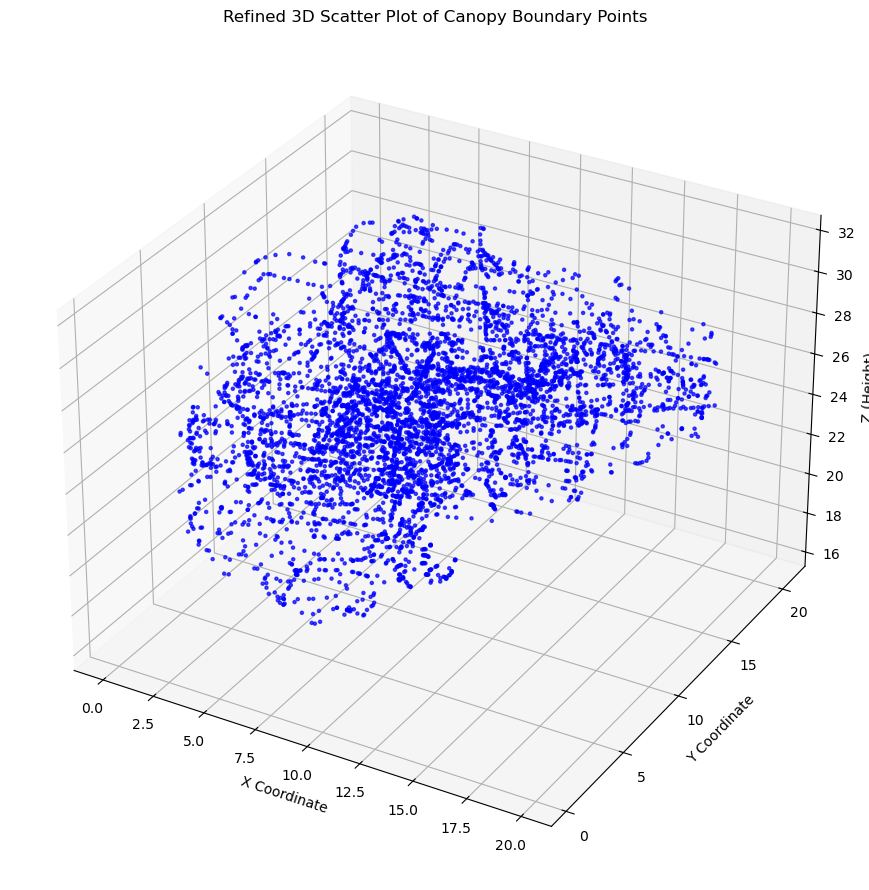

Displayed Slabs: 4904


In [5]:
canopy_points = []  # Store all boundary points from slabs

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for i, slab in enumerate(slabs):
    if slab.shape[0] < 10:
        continue  # Skip small slabs

    projected = slab[:, :2]

    # Skip slabs that are too narrow to form meaningful shapes
    bbox = np.ptp(projected, axis=0)
    if np.any(bbox < 0.5):  # You can adjust this threshold
        continue

    # Estimate alpha dynamically based on spread (heuristic)
    spread = np.linalg.norm(bbox)
    alpha = 0.05 * spread  # Adjust multiplier if needed

    try:
        alpha_shape = alphashape.alphashape(projected, alpha)

        if isinstance(alpha_shape, Polygon):  # Valid single polygon
            boundary = np.array(alpha_shape.exterior.coords)
            canopy_points.append(boundary)

            z_level = np.mean(slab[:, 2])
            ax.scatter(boundary[:, 0], boundary[:, 1],np.full_like(boundary[:, 0], z_level),color='blue', s=5, alpha=0.7)

    except Exception as e:
        print(f"[Slab {i}] Alpha shape failed: {e}")

# Plot formatting
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z (Height)")
ax.set_title("Refined 3D Scatter Plot of Canopy Boundary Points")
plt.tight_layout()
plt.show()

print("Displayed Slabs:", len(selected_slab))

Total branches stored: 15293
Total segments stored: 12921


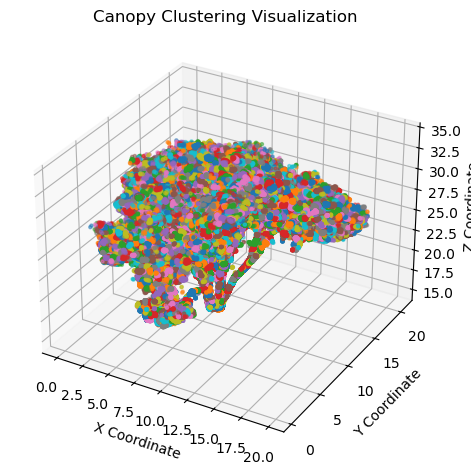

In [6]:
import os
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

# Assume 'points' and 'c' are defined earlier in your code
# Example:
# points = np.loadtxt('your_crown_points.txt')  # Nx3 numpy array
# c = 0.3  # canopy interval or resolution in Z

# Initialize global branches storage
global_branches = {}

# Create output folder for segments
os.makedirs("segments", exist_ok=True)
segment_id = 1  # Segment file counter

# Step 2: Clustering process
tree = KDTree(points)

# Function to find neighboring points
def find_neighbors(point, radius):
    indices = tree.query_ball_point(point, radius)
    return points[indices]

# Initialize variables
clusters = []
processed_points = set()
initial_radius = 0.3

# Iterating over canopy points
for canopy_point in points:
    if tuple(canopy_point) in processed_points:
        continue

    # Step ii: Form initial sphere
    cluster = []
    radius = initial_radius
    seed_point = canopy_point

    while True:
        neighbors = find_neighbors(seed_point, radius)
        if len(neighbors) < 2:
            break  # No meaningful cluster

        # Step iii: Compute distances
        distances = np.linalg.norm(neighbors - seed_point, axis=1)
        farthest_point = neighbors[np.argmax(distances)]

        # Step iv: Increase sphere radius
        radius += 0.015

        # Step v: Exclude previously processed points
        new_points = [tuple(p) for p in neighbors if tuple(p) not in processed_points]
        cluster.extend(new_points)
        processed_points.update(new_points)

        # Step vi-vii: Detect joints
        joint_candidates = [
            p for p in cluster
            if np.sum([np.linalg.norm(np.array(p) - np.array(q)) < radius for q in cluster]) > 2
        ]

        # ✅ Save segment if joint is detected
        if joint_candidates:
            segment_array = np.array(cluster, dtype=float)
            segment_path = os.path.join("segments", f"segment_{segment_id}.txt")
            np.savetxt(segment_path, segment_array, fmt="%.6f", header="x y z", comments='')
            segment_id += 1

        # Step x: Termination condition
        Cw = np.sqrt((np.max(points[:, 0]) - np.min(points[:, 0]))**2 +
                     (np.max(points[:, 1]) - np.min(points[:, 1]))**2)
        Ch = (np.max(points[:, 2]) - np.min(points[:, 2])) / c
        threshold_N = np.sqrt((Cw * 0.5) ** 2 + (Ch) ** 2) / radius
        if len(new_points) < threshold_N:
            break

    # Store cluster as a branch in global_branches
    branch_key = f"branch_{len(global_branches)+1}"
    global_branches[branch_key] = {"points": np.array(cluster, dtype=float), "radius": radius}
    clusters.append(cluster)

# Print summary
print(f"Total branches stored: {len(global_branches)}")
print(f"Total segments stored: {segment_id - 1}")

# Visualization of all branches
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for branch_data in global_branches.values():
    cluster_points = np.array(branch_data["points"], dtype=float)
    if cluster_points.ndim == 1:
        cluster_points = cluster_points.reshape(-1, 3)
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], alpha=0.5, s=5)

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("Canopy Clustering Visualization")
plt.tight_layout()
plt.show()


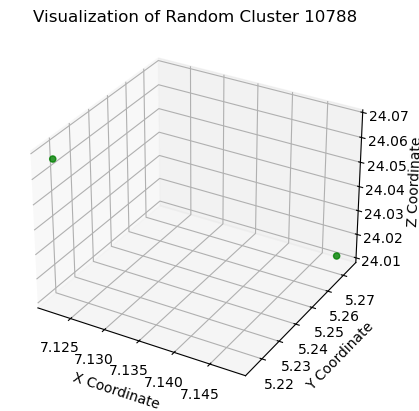

In [7]:
# Choose a random cluster index 3989
random_index = random.randint(0, len(clusters) - 1)
random_cluster = clusters[random_index]

# Convert to NumPy array for plotting
random_cluster_points = np.array(random_cluster, dtype=float)

# Ensure it's a valid 2D array
if len(random_cluster_points.shape) == 1:
    random_cluster_points = random_cluster_points.reshape(-1, 3)

# Visualization of the selected random cluster
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(random_cluster_points[:, 0], random_cluster_points[:, 1], random_cluster_points[:, 2], alpha=0.8, color='green')

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title(f"Visualization of Random Cluster {random_index}")

plt.show()

In [8]:
def divide_cluster(cluster_points):
    Nc = len(cluster_points)

    if Nc < 2:  # Ensure at least two points for distance calculation
        return [cluster_points]  # Return as a single dataset

    # Compute average pairwise distance Da
    distances = pdist(cluster_points)
    if distances.size == 0 or np.isnan(distances).any():
        return [cluster_points]  # Avoid NaN issues

    Da = np.nanmean(distances)  # Use np.nanmean to handle NaN values safely

    # Compute K and Nd
    K = max(1, round(100 / Da)) if Da > 0 else 1
    Nd = max(1, Nc // K)

    # Split cluster into Nd datasets
    datasets = np.array_split(cluster_points, Nd)

    return datasets

# Process clusters
Nd_datasets = []
for cluster in clusters:
    Nd_datasets.append(divide_cluster(cluster))

In [9]:
def compute_perpendicular_distance(pt, line_pt, line_dir):
    """
    Compute perpendicular distance and sign relative to the main PCA-fitted axis.
    """
    vec = pt - line_pt
    projection = np.dot(vec, line_dir) * line_dir
    perpendicular_vector = vec - projection
    return np.linalg.norm(perpendicular_vector), np.sign(np.dot(vec, line_dir))

def fit_3d_line(points):
    """
    Fit a PCA-based line through the dataset.
    Returns the principal direction and centroid.
    """
    if len(points) < 2:
        return None, None
    pca = PCA(n_components=1)
    pca.fit(points)
    return pca.components_[0], pca.mean_

def degroup_branch(branch_points_array):
    """
    Given a branch's 3D points, fit a PCA line and split into four subgroups.
    """
    if len(branch_points_array) == 0:
        return np.empty((0, 3)), np.empty((0, 3)), np.empty((0, 3)), np.empty((0, 3))

    line_dir, line_pt = fit_3d_line(branch_points_array)
    if line_dir is None:
        return (branch_points_array.copy(),
                np.empty((0, 3)),
                np.empty((0, 3)),
                np.empty((0, 3)))

    group1, group2 = [], []
    for pt in branch_points_array:
        _, sgn = compute_perpendicular_distance(pt, line_pt, line_dir)
        if sgn >= 0:
            group1.append(pt)
        else:
            group2.append(pt)
    group1, group2 = np.array(group1), np.array(group2)

    sub_1a = sub_1b = sub_2a = sub_2b = np.empty((0, 3))

    if len(group1) > 1:
        dir1, pt1 = fit_3d_line(group1)
        tmp1a, tmp1b = [], []
        for pt in group1:
            _, sgn = compute_perpendicular_distance(pt, pt1, dir1)
            if sgn >= 0:
                tmp1a.append(pt)
            else:
                tmp1b.append(pt)
        sub_1a, sub_1b = np.array(tmp1a), np.array(tmp1b)

    if len(group2) > 1:
        dir2, pt2 = fit_3d_line(group2)
        tmp2a, tmp2b = [], []
        for pt in group2:
            _, sgn = compute_perpendicular_distance(pt, pt2, dir2)
            if sgn >= 0:
                tmp2a.append(pt)
            else:
                tmp2b.append(pt)
        sub_2a, sub_2b = np.array(tmp2a), np.array(tmp2b)

    return sub_1a, sub_1b, sub_2a, sub_2b

In [10]:
# Initialize a list to store all subgrouped datasets
subgrouped_datasets = []

# Loop through each dataset in Nd_datasets and apply subgrouping
for dataset_group in Nd_datasets:  # Since Nd_datasets is nested
    for dataset in dataset_group:
        # Apply subgrouping using `degroup_branch`
        sub_1a, sub_1b, sub_2a, sub_2b = degroup_branch(dataset)

        # Store each subgroup separately
        subgrouped_datasets.append(sub_1a)
        subgrouped_datasets.append(sub_1b)
        subgrouped_datasets.append(sub_2a)
        subgrouped_datasets.append(sub_2b)

print(f"Total datasets processed: {len(Nd_datasets)}")
print(f"Total subgrouped datasets stored: {len(subgrouped_datasets)}")

C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anacond

Total datasets processed: 15293
Total subgrouped datasets stored: 61520


In [11]:
class Cylinder:
    """Implementation for cylinder RANSAC."""

    def __init__(self):
        self.inliers = []
        self.center = []
        self.axis = []
        self.radius = 0

    def fit(self, pts, thresh=0.2, maxIteration=100):
        """
        Find the parameters defining a cylinder using RANSAC.

        Args:
            pts (np.ndarray): Nx3 array of 3D points.
            thresh (float): Distance threshold to consider a point an inlier.
            maxIteration (int): Maximum number of RANSAC iterations.

        Returns:
            tuple: (center, axis, radius, inliers_idx) of the best-fitting cylinder.
        """

        n_points = pts.shape[0]
        best_inliers = []

        for _ in range(maxIteration):
            # Need at least 3 points to define a plane for the initial circle
            if n_points < 3:
                continue

            # Randomly sample 3 points
            id_samples = random.sample(range(0, n_points), 3)
            pt_samples = pts[id_samples]

            # Calculate vectors between sample points
            vecA = pt_samples[1, :] - pt_samples[0, :]
            vecB = pt_samples[2, :] - pt_samples[0, :]

            # Compute the cylinder axis candidate (normal to the plane formed by the 3 points)
            # This is an initial estimate and will be refined.
            vecC_candidate = np.cross(vecA, vecB)

            # If the points are collinear or close to it, cross product might be zero
            if np.linalg.norm(vecC_candidate) < 1e-6:
                continue

            vecC_candidate = vecC_candidate / np.linalg.norm(vecC_candidate)

            # Project points onto a plane perpendicular to vecC_candidate to find circle parameters
            # Rotate points so vecC_candidate aligns with [0,0,1]
            P_rot = rodrigues_rot(pt_samples, vecC_candidate, [0, 0, 1])

            # Find the circumcenter of the projected points (center of the circle)
            # This involves finding the intersection of perpendicular bisectors
            # Using a more robust method for calculating the circumcenter

            # Check for collinearity in 2D projected points
            if np.linalg.norm(P_rot[1, :2] - P_rot[0, :2]) < 1e-6 or \
               np.linalg.norm(P_rot[2, :2] - P_rot[1, :2]) < 1e-6 or \
               np.linalg.norm(P_rot[2, :2] - P_rot[0, :2]) < 1e-6:
                continue # Points are too close or collinear in 2D, skip this sample

            A = P_rot[0, :2]
            B = P_rot[1, :2]
            C = P_rot[2, :2]

            D = 2 * (A[0] * (B[1] - C[1]) + B[0] * (C[1] - A[1]) + C[0] * (A[1] - B[1]))

            if abs(D) < 1e-6: # Check if D is close to zero (collinear points)
                continue

            p_center_x = (
                (A[0]**2 + A[1]**2) * (B[1] - C[1]) +
                (B[0]**2 + B[1]**2) * (C[1] - A[1]) +
                (C[0]**2 + C[1]**2) * (A[1] - B[1])
            ) / D
            p_center_y = (
                (A[0]**2 + A[1]**2) * (C[0] - B[0]) +
                (B[0]**2 + B[1]**2) * (A[0] - C[0]) +
                (C[0]**2 + C[1]**2) * (B[0] - A[0])
            ) / D

            p_center = np.array([p_center_x, p_center_y, 0])
            radius = np.linalg.norm(p_center - P_rot[0, :])

            if radius < 1e-6: # Check for a valid radius (should be positive)
                continue

            # Rotate the center back to the original coordinate system
            center = rodrigues_rot(p_center, [0, 0, 1], vecC_candidate)[0]

            # Calculate distances of all points to the estimated cylinder surface
            vecC_stacked = np.stack([vecC_candidate] * n_points, axis=0)

            # Perpendicular distance from each point to the line (cylinder axis)
            dist_point_to_axis = np.linalg.norm(np.cross(vecC_stacked, (pts - center)), axis=1)

            # Inliers are points whose distance to the cylinder surface is within the threshold
            pt_id_inliers = np.where(np.abs(dist_point_to_axis - radius) <= thresh)[0]

            # Update best fit if current model has more inliers
            if len(pt_id_inliers) > len(best_inliers):
                best_inliers = pt_id_inliers
                self.inliers = best_inliers
                self.center = center
                self.axis = vecC_candidate
                self.radius = radius

        return self.center, self.axis, self.radius, self.inliers


def rodrigues_rot(P, n0, n1):
    """
    Rotate a set of points between two normal vectors using Rodrigues' formula.

    Args:
        P (np.ndarray): Points to rotate (Nx3 or 1x3 array).
        n0 (np.ndarray): Initial normal vector.
        n1 (np.ndarray): Target normal vector.

    Returns:
        np.ndarray: Rotated points.
    """

    P = np.asarray(P)
    if P.ndim == 1:
        P = P[np.newaxis, :]

    n0 = n0 / np.linalg.norm(n0)
    n1 = n1 / np.linalg.norm(n1)
    k = np.cross(n0, n1)
    P_rot = np.zeros((len(P), 3))

    # Handle the case where n0 and n1 are parallel or anti-parallel
    if np.linalg.norm(k) < 1e-6: # k is close to zero vector (n0 and n1 are parallel or anti-parallel)
        if np.dot(n0, n1) > 0.999: # n0 and n1 are nearly parallel
            return P # No rotation needed
        else: # n0 and n1 are nearly anti-parallel, rotate by 180 degrees around an arbitrary perpendicular axis
            # Find an arbitrary vector perpendicular to n0 (e.g., if n0 is [0,0,1], use [1,0,0])
            if np.allclose(n0, [0,0,1]):
                k_prime = np.array([1,0,0])
            else:
                k_prime = np.cross(n0, [0,0,1])
            k_prime = k_prime / np.linalg.norm(k_prime)
            theta = np.pi # 180 degrees
            for i in range(len(P)):
                P_rot[i] = P[i] * np.cos(theta) + np.cross(k_prime, P[i]) * np.sin(theta) + k_prime * np.dot(k_prime, P[i]) * (1 - np.cos(theta))
            return P_rot
    else: # n0 and n1 are not parallel
        k = k / np.linalg.norm(k) # Normalize rotation axis
        theta = np.arccos(np.dot(n0, n1)) # Angle of rotation

        for i in range(len(P)):
            P_rot[i] = (
                P[i] * np.cos(theta) + np.cross(k, P[i]) * np.sin(theta) + k * np.dot(k, P[i]) * (1 - np.cos(theta))
            )
    return P_rot

In [12]:
def fit_cylinder_with_class(branch_points, cylinder):
    """
    Fit a cylinder to a given merged branch dataset using the Cylinder class.
    Returns center, axis direction, diameter, and height.
    """
    if len(branch_points) < 2:
        return None  # Not enough points for fitting

    # Call cylinder fitting method
    center, axis, radius, inliers_idx = cylinder.fit(branch_points)
    if isinstance(axis, list):
        axis = np.array(axis)
    if center is None or axis is None or axis.size == 0:
        return None # Return None if fitting failed or axis is invalid

    # Compute height: Max projection along axis
    projections = np.dot(branch_points - center, axis)
    height = np.max(projections) - np.min(projections)

    # Compute diameter from fitted radius
    diameter = 2 * abs(radius)

    return center, axis, diameter, height

def merge_datasets(dataset1, dataset2):
    temp_cylinder = Cylinder() # Instantiate Cylinder for fitting

    # Fit cylinders using the proper function
    res1 = fit_cylinder_with_class(dataset1, temp_cylinder)
    res2 = fit_cylinder_with_class(dataset2, temp_cylinder)

    # Check if fitting was successful for both
    if res1 is None or res2 is None:
        print("Cylinder fitting failed for one or both datasets during merge attempt.")
        return None

    # Extract center and axis from the results of fit_cylinder_with_class
    center1, axis1, _, _ = res1
    center2, axis2, _, _ = res2

    # Ensure axes are valid before normalization and dot product
    if axis1 is None or axis2 is None or np.linalg.norm(axis1) == 0 or np.linalg.norm(axis2) == 0:
        print("Invalid or zero-length axis from cylinder fit, cannot compute angular deviation.")
        return None

    # Compute angular deviation
    norm_axis1 = np.linalg.norm(axis1)
    norm_axis2 = np.linalg.norm(axis2)
    # Use clip to avoid arccos of values slightly outside [-1, 1] due to floating point inaccuracies
    dot_product_normalized = np.dot(axis1, axis2) / (norm_axis1 * norm_axis2)
    angle_rad = np.arccos(np.clip(dot_product_normalized, -1.0, 1.0))
    angle_deg = np.degrees(angle_rad)

    # Compute centroid distance
    centroid_distance = np.linalg.norm(center1 - center2)

    # Check merging conditions
    if angle_deg < 2.5 and centroid_distance < 0.04:
        merged_dataset = np.vstack([dataset1, dataset2])
        print("Merging datasets into one branch structure.")
        return merged_dataset
    else:
        print("Datasets remain separate.")
        return None

In [13]:
def remove_leaf_noise(subgroup_points):
    """
    Remove leaf noise using RANSAC-fitted cylinder axis.
    If the number of points in a subgroup is less than 7, they are kept aside.
    For subgroups with 7 or more points, RANSAC is applied.
    """

    if len(subgroup_points) < 7:
        print(f"Subgroup has {len(subgroup_points)} points, keeping aside (no RANSAC applied).")
        return subgroup_points.copy()  # Return unchanged if too few points

    # Apply RANSAC for subgroups with 7 or more points
    cylinder = Cylinder()
    center, axis, radius, inliers_idx = cylinder.fit(subgroup_points)

    # Convert `axis` to a NumPy array
    axis = np.array(axis)

    # Ensure axis and center are valid (not empty or None)
    if axis is None or axis.size == 0 or center is None or center.size == 0:
        print("Warning: Cylinder fitting failed, skipping leaf removal for this subgroup.")
        return subgroup_points.copy()

    # Normalize cylinder axis
    radius = abs(radius)
    axis = axis / np.linalg.norm(axis)  # Ensure it's a unit vector

    # Apply kNN to find neighbors
    kNN = NearestNeighbors(n_neighbors=3)
    kNN.fit(subgroup_points)

    # Leaf Removal Process
    on_branch_dataset = []
    for i, point in enumerate(subgroup_points):
        distances, indices = kNN.kneighbors(point.reshape(1, -1))

        if len(indices[0]) < 3:  # Ensure at least 3 neighbors exist
            continue

        neighbor_indices = indices[0]
        plane_points = subgroup_points[neighbor_indices]

        # Define plane normal using cross product
        plane_vector1 = plane_points[1] - plane_points[0]
        plane_vector2 = plane_points[2] - plane_points[0]
        plane_normal = np.cross(plane_vector1, plane_vector2)

        # Ensure plane_normal is valid
        if plane_normal.size == 0 or np.linalg.norm(plane_normal) == 0:
            continue

        # Dot product between plane normal and cylinder axis
        dot_product = abs(np.dot(plane_normal, axis))

        # Compute threshold Td
        Dg = np.linalg.norm(point - center)
        Td = 0.08 * (1 + 0.5 * Dg)

        if dot_product < Td:
            on_branch_dataset.append(point)  # Keep only branch points

    print(f"Leaf noise removed. {len(on_branch_dataset)} points retained as 'on-branch'.")
    return np.array(on_branch_dataset)

In [14]:
# Initialize a container for cleaned subgroups (size >= 7)
processed_large_subgroups = []
# Initialize a container for subgroups kept aside (size < 7)
kept_aside_small_subgroups = []

for seed, branch in global_branches.items():
    pts_array = np.array(list(branch["points"]))
    s1a, s1b, s2a, s2b = degroup_branch(pts_array) # This gives 4 subgroups

    for subgroup in [s1a, s1b, s2a, s2b]:
        if subgroup.size > 0:
            if len(subgroup) < 7:
                kept_aside_small_subgroups.append(subgroup)
            else:
                cleaned = remove_leaf_noise(subgroup)
                if cleaned.size > 0: # Only add if still has points after leaf removal
                    processed_large_subgroups.append(cleaned)

print(f"Initial large subgroups (after noise removal): {len(processed_large_subgroups)}")
print(f"Initial small subgroups (kept aside): {len(kept_aside_small_subgroups)}")

Leaf noise removed. 323 points retained as 'on-branch'.
Leaf noise removed. 373 points retained as 'on-branch'.
Leaf noise removed. 329 points retained as 'on-branch'.
Leaf noise removed. 470 points retained as 'on-branch'.
Leaf noise removed. 268 points retained as 'on-branch'.
Leaf noise removed. 205 points retained as 'on-branch'.
Leaf noise removed. 243 points retained as 'on-branch'.
Leaf noise removed. 199 points retained as 'on-branch'.


C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 199 points retained as 'on-branch'.
Leaf noise removed. 240 points retained as 'on-branch'.
Leaf noise removed. 202 points retained as 'on-branch'.
Leaf noise removed. 200 points retained as 'on-branch'.
Leaf noise removed. 337 points retained as 'on-branch'.
Leaf noise removed. 317 points retained as 'on-branch'.
Leaf noise removed. 343 points retained as 'on-branch'.
Leaf noise removed. 321 points retained as 'on-branch'.
Leaf noise removed. 240 points retained as 'on-branch'.
Leaf noise removed. 383 points retained as 'on-branch'.
Leaf noise removed. 393 points retained as 'on-branch'.
Leaf noise removed. 410 points retained as 'on-branch'.
Leaf noise removed. 378 points retained as 'on-branch'.
Leaf noise removed. 427 points retained as 'on-branch'.
Leaf noise removed. 440 points retained as 'on-branch'.
Leaf noise removed. 403 points retained as 'on-branch'.
Leaf noise removed. 502 points retained as 'on-br

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)
C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 239 points retained as 'on-branch'.
Leaf noise removed. 244 points retained as 'on-branch'.
Leaf noise removed. 226 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf nois

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 66 points retained as 'on-branch'.
Leaf noise removed. 62 points retained as 'on-branch'.
Leaf noise removed. 56 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 65 points retained as 'on-branch'.
Leaf noise removed. 67 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 68 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 106 points retained as 'on-branch'.
Leaf noise removed. 66 points retained as 'on-branch'.
Leaf noise removed. 71 points retained as 'on-branch'.
Leaf noise removed. 78 points retained as 'on-branch'.
Leaf noise removed. 71 points retained as 'on-branch'.
Leaf noise removed. 44 points retained as 'on-branch'.
Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 39 points retained as 'on-branch'.
Leaf noise removed. 177 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 43 points retained as 'on-branch'.
Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noi

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 43 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise remove

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 52 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise re

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noise removed. 63 points retained as 'on-branch'.
Leaf noise removed. 55 points retained as 'on-branch'.
Leaf noise removed. 68 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 80 points retained as 'on-branch'.
Leaf noise removed. 63 points retained as 'on-branch'.
Leaf noise re

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 49 points retained as 'on-branch'.
Leaf noise removed. 39 points retained as 'on-branch'.
Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 36 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 106 points retained as 'on-branch'.
Leaf noise removed. 2 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 45 points retained as 'on-branch'.
Leaf noise removed. 63 points retained as 'on-branch'.
Leaf noise removed. 44 points retained as 'on-branch'.
Leaf noise removed. 47 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 80 points retained as 'on-branch'.
Leaf noise removed. 66 points retained as 'on-branch'.
Leaf noise removed. 57 points retained as 'on-branch'.
Leaf noise removed. 55 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise re

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 42 points retained as 'on-branch'.
Leaf noise removed. 46 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise rem

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 84 points retained as 'on-branch'.
Leaf noise removed. 60 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 42 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noise removed. 53 points retained as 'on-branch'.
Leaf noise removed. 46 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 39 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 59 points retained as 'on-branch'.
Leaf noise removed. 52 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise re

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 36 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 52 points retained as 'on-branch'.
Leaf noise removed. 67 points retained as 'on-branch'.
Leaf noise removed. 85 points retained as 'on-branch'.
Leaf noise removed. 103 points retained as 'on-branch'.
Leaf noise removed. 76 points retained as 'on-branch'.
Leaf noise removed. 102 points retained as 'on-branch'.
Leaf noi

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 53 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 3 points retained as 'on-branch'.
Leaf noise removed. 49 points retained as 'on-branch'.
Leaf noise removed. 5 points retained as 'on-branch'.
Leaf noise removed. 39 points retained as 'on-branch'.
Leaf noise removed. 2 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 0 po

C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Leaf noise removed. 72 points retained as 'on-branch'.
Leaf noise removed. 84 points retained as 'on-branch'.
Leaf noise removed. 120 points retained as 'on-branch'.
Leaf noise removed. 93 points retained as 'on-branch'.
Leaf noise removed. 58 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 47 points retained as 'on-branch'.
Leaf noise removed. 69 points retained as 'on-branch'.
Leaf noise removed. 62 points retained as 'on-branch'.
Leaf noise removed. 45 points retained as 'on-branch'.
Leaf noise removed. 49 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf nois

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 45 points retained as 'on-branch'.
Leaf noise removed. 45 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 66 points retained as 'on-branch'.
Leaf noise removed. 77 points retained as 'on-branch'.
Leaf noise removed. 62 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noise removed. 54 points retained as 'on-branch'.
Leaf noise removed. 48 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise r

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 46 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 47 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 55 points retained as 'on-branch'.
Leaf noise removed. 44 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 65 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 36 points retained as 'on-branch'.
Leaf noise removed. 47 points retained as 'on-branch'.
Leaf noise removed. 59 points retained as 'on-branch'.
Leaf noise removed. 54 points retained as 'on-branch'.
Leaf noise re

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 147 points retained as 'on-branch'.
Leaf noise removed. 158 points retained as 'on-branch'.
Leaf noise removed. 151 points retained as 'on-branch'.
Leaf noise removed. 149 points retained as 'on-branch'.
Leaf noise removed. 165 points retained as 'on-branch'.
Leaf noise removed. 169 points retained as 'on-branch'.
Leaf noise removed. 47 points retained as 'on-branch'.
Leaf noise removed. 79 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 181 points retained as 'on-branch'.
Leaf noise removed. 155 points retained as 'on-branch'.
Leaf noise removed. 44 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 53 points retained as 'on-branch'.
Leaf noise removed. 54 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Lea

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 55 points retained as 'on-branch'.
Leaf noise removed. 63 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 62 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 69 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 72 points retained as 'on-branch'.
Leaf noise removed. 80 points retained as 'on-branch'.
Leaf noise removed. 87 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 46 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 43 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 53 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 102 points retained as 'on-branch'.
Leaf noise removed. 77 points retained as 'on-branch'.
Leaf noise removed. 63 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 43 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 76 points retained as 'on-branch'.
Leaf noise removed. 76 points retained as 'on-branch'.
Leaf noise removed. 72 points retained as 'on-branch'.
Leaf noise removed. 62 points retained as 'on-branch'.
Leaf noise removed. 69 points retained as 'on-branch'.
Leaf nois

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 44 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 39 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 82 points retained as 'on-branch'.
Leaf noise removed. 84 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 64 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 47 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 48 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 48 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise rem

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 44 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 48 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 91 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 114 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 51 points retained as 'on-branch'.
Leaf noise removed. 53 points retained as 'on-branch'.
Leaf noise removed. 60 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 42 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 81 points retained as 'on-branch'.
Leaf noise removed. 58 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 54 points retained as 'on-branch'.
Leaf noise removed. 56 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 56 points retained as 'on-branch'.
Leaf noise removed. 60 points retained as 'on-branch'.
Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noise removed. 43 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 53 points retained as 'on-branch'.
Leaf noise removed. 42 points retained as 'on-branch'.
Leaf noise removed. 58 points retained as 'on-branch'.
Leaf noise removed. 90 points retained as 'on-branch'.
Leaf noise removed. 67 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 91 points retained as 'on-branch'.
Leaf noise removed. 80 points retained as 'on-branch'.
Leaf noise removed. 44 points retained as 'on-branch'.
Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noise removed. 39 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 80 points retained as 'on-branch'.
Leaf noise removed. 94 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 56 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 74 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 83 points retained as 'on-branch'.
Leaf noise removed. 61 points retained as 'on-branch'.
Leaf noise removed. 82 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 43 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 48 points retained as 'on-branch'.
Leaf noise removed. 81 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise re

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 88 points retained as 'on-branch'.
Leaf noise removed. 65 points retained as 'on-branch'.
Leaf noise removed. 51 points retained as 'on-branch'.
Leaf noise removed. 52 points retained as 'on-branch'.
Leaf noise removed. 73 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 42 points retained as 'on-branch'.
Leaf noise removed. 91 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 51 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 47 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 39 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 45 points retained as 'on-branch'.
Leaf noise removed. 39 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.


C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.


C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise rem

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed.

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 49 points retained as 'on-branch'.
Leaf noise removed. 36 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise remov

C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Leaf noise removed. 3 points retained as 'on-branch'.
Leaf noise removed. 47 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 51 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 39 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise rem

C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.


C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 45 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 50 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 34 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 66 points retained as 'on-branch'.
Leaf noise removed. 58 points retained as 'on-branch'.
Leaf noise removed. 62 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 41 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise rem

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 44 points retained as 'on-branch'.
Leaf noise removed. 43 points retained as 'on-branch'.
Leaf noise removed. 44 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 48 points retained as 'on-branch'.
Leaf noise removed. 45 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.


C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise remov

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.


C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 31 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise rem

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 54 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.


C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 39 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 46 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 29 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise remov

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.


C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 40 points retained as 'on-branch'.
Leaf noise removed. 45 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise re

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise remov

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 45 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 32 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 35 points retained as 'on-branch'.
Leaf noise removed. 36 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 23 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise re

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise remov

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise r

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 1

C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.


C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 51 points retained as 'on-branch'.
Leaf noise removed. 59 points retained as 'on-branch'.
Leaf noise removed. 64 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise rem

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise remo

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise remove

C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 33 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 26 points retained as 'on-branch'.
Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 76 points retained as 'on-branch'.
Leaf noise removed. 106 points retained as 'on-branch'.
Leaf noise removed. 82 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise rem

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 28 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise remov

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)
C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 0 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.


C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Leaf noise removed. 19 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 

C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 15 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 11 points retained as 'on-branch'.
Leaf noise removed. 12 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 10 points retained as 'on-branch'.
Leaf noise removed. 9 points retained as 'on-branch'.
Leaf noise removed. 8 points retained as 'on-branch'.
Leaf noise removed. 25 points retained as 'on-branch'.
Leaf noise removed. 13 points retained as 'on-branch'.
Leaf noise removed. 7 points retained as 'on-branch'.
Leaf noise removed

C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\Personal\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:653: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


Leaf noise removed. 16 points retained as 'on-branch'.
Leaf noise removed. 21 points retained as 'on-branch'.
Leaf noise removed. 17 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 18 points retained as 'on-branch'.
Leaf noise removed. 14 points retained as 'on-branch'.
Leaf noise removed. 42 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise removed. 38 points retained as 'on-branch'.
Leaf noise removed. 22 points retained as 'on-branch'.
Leaf noise removed. 37 points retained as 'on-branch'.
Leaf noise removed. 27 points retained as 'on-branch'.
Leaf noise removed. 24 points retained as 'on-branch'.
Leaf noise removed. 20 points retained as 'on-branch'.
Leaf noise removed. 30 points retained as 'on-branch'.
Leaf noise

In [15]:
from scipy.spatial import KDTree
import numpy as np

# --- Step 1: Merging Large Subgroups Based on 2 Nearest Neighbors ---

merged_large_branches = []
merged_indices = set()

# Compute centroids of all large subgroups
large_centroids = [np.mean(subgroup, axis=0) for subgroup in processed_large_subgroups]
large_tree = KDTree(large_centroids)

for i in range(len(processed_large_subgroups)):
    if i in merged_indices:
        continue

    current_branch = processed_large_subgroups[i]
    merged_indices.add(i)

    # Find 2 nearest neighbors (excluding self)
    distances, neighbor_indices = large_tree.query(large_centroids[i], k=3)  # k=3 includes self
    neighbors = [idx for idx in neighbor_indices if idx != i][:2]

    for j in neighbors:
        if j in merged_indices:
            continue

        if current_branch.size > 0 and processed_large_subgroups[j].size > 0:
            potential_merge = merge_datasets(current_branch, processed_large_subgroups[j])
            if potential_merge is not None:
                current_branch = potential_merge
                merged_indices.add(j)

    if current_branch.size > 0:
        merged_large_branches.append(current_branch)

print(f"✅ Merged large branches: {len(merged_large_branches)}")

# --- Step 2: Merging Small Subgroups (Same Logic) ---
final_merged_branches_with_small = list(merged_large_branches)
waste_points_count = 0

for small_subgroup in kept_aside_small_subgroups:
    if small_subgroup.size == 0:
        continue

    if len(small_subgroup) <= 2:
        continue  # Ignore subgroups with 2 or fewer points

    small_centroid = np.mean(small_subgroup, axis=0)

    if len(small_subgroup) == 3:
        # Merge with nearest branch
        branch_centroids = [np.mean(b, axis=0) for b in final_merged_branches_with_small]
        branch_tree = KDTree(branch_centroids)
        _, nearest_idx = branch_tree.query(small_centroid)
        final_merged_branches_with_small[nearest_idx] = np.vstack([
            final_merged_branches_with_small[nearest_idx], small_subgroup
        ])
        
        continue

        # --- Use RANSAC-based fit for angle and radius verification ---
    found_merge = False

    try:
        small_axis, small_radius, _, _ = fit_cylinder_ransac(small_subgroup)
    except:
        continue  # Skip this subgroup if cylinder fitting fails

    for i, branch in enumerate(final_merged_branches_with_small):
        if branch.size == 0:
            continue

        branch_centroid = np.mean(branch, axis=0)
        small_centroid = np.mean(small_subgroup, axis=0)

        if np.linalg.norm(small_centroid - branch_centroid) >= 0.04:
            continue  # Too far, skip

        try:
            branch_axis, branch_radius, _, _ = fit_cylinder_ransac(branch)
        except:
            continue  # Skip this branch if cylinder fitting fails

        angle = angle_between_vectors(small_axis, branch_axis)
        if angle > 1.5:
            continue  # Angle too different

        radius_diff_percent = abs(branch_radius - small_radius) / max(branch_radius, 1e-6) * 100
        if radius_diff_percent > 5:
            continue  # Radius too different

        # ✅ Passed all checks, merge!
        final_merged_branches_with_small[i] = np.vstack([branch, small_subgroup])
        found_merge = True
        break

    if not found_merge:
        waste_points_count += len(small_subgroup)

final_merged_branches = final_merged_branches_with_small

# --- Output Summary ---
print(f"✅ Total final merged branches stored: {len(final_merged_branches)}")
print(f"🗑️ Total waste points (discarded subgroups not merged): {waste_points_count}")
print("✅ Program completed successfully in Jupyter Notebook.")

# --- Optional: Access or Visualize Final Merged Branches ---
# For example, show one of them:
# display(final_merged_branches[0])  # or use matplotlib if needed

# Clean up memory (optional in Jupyter)
# import gc; gc.collect()


Cylinder fitting failed for one or both datasets during merge attempt.
Merging datasets into one branch structure.
Datasets remain separate.
Datasets remain separate.
Cylinder fitting failed for one or both datasets during merge attempt.
Cylinder fitting failed for one or both datasets during merge attempt.
Merging datasets into one branch structure.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Merging datasets into one branch structure.
Datasets remain separate.
Merging datasets into one branch structure.
Cylinder fitting failed for one or both datasets during merge attempt.
Merging datasets into one branch structure.


C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


Merging datasets into one branch structure.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Cylinder fitting failed for one or both datasets during merge attempt.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Cylinder fitting failed for one or both datasets during merge attempt.
Cylinder fitting failed for one or both datasets during merge attempt.
Datasets remain separate.
Datasets remain separate.
Merging datasets into one branch structure.
Datasets remain separate.
Merging datasets into one branch structure.
Cylinder fitting failed for one or both datasets during merge attempt.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Datasets remain separate.
Merging datasets into one branch struc

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Utility Functions ---
def compute_volume(diameter, height):
    """Compute volume of a cylinder."""
    radius = diameter / 2
    return np.pi * (radius ** 2) * height

def compute_surface_density(branch_points, volume):
    """Compute surface data density: Number of points per unit volume."""
    return len(branch_points) / volume if volume > 0 else 0

# --- Initialize Cylinder class ---
cylinder = Cylinder()  # Ensure this class is implemented correctly

volume_data = []
density_data = []
skeleton_segments = []

# --- Fit cylinders to branches and compute values ---
for branch in final_merged_branches:
    try:
        result = fit_cylinder_with_class(branch, cylinder)
        if result:
            center, axis, diameter, height = result
            volume = compute_volume(diameter, height)
            density = compute_surface_density(branch, volume)

            volume_data.append(volume)
            density_data.append(density)

            # Compute skeleton line segment
            axis_unit = axis / np.linalg.norm(axis)
            start_point = center - (axis_unit * height / 2)
            end_point = center + (axis_unit * height / 2)
            skeleton_segments.append((start_point, end_point))

    except Exception as e:
        print(f"⚠️ Skipping a branch due to error: {e}")
        continue



C:\Users\Personal\AppData\Local\Temp\ipykernel_332\350026209.py:144: RuntimeWarning: invalid value encountered in divide
  k_prime = k_prime / np.linalg.norm(k_prime)


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# --- Option 1: Visualize Skeleton Segments ---
# This assumes 'skeleton_segments' is a list where each element is
# a tuple or list of two points (start_point, end_point) for a line segment.
# Replace this dummy data with your actual 'skeleton_segments' list
# from your previous processing.
# Example: skeleton_segments = [([0,0,0], [0,0,1]), ([1,1,1], [1,1,2])]
if 'skeleton_segments' not in locals() or not skeleton_segments:
    print("WARNING: 'skeleton_segments' not found or empty. Using dummy data for visualization.")
    # Dummy data for demonstration if actual data is not available
    skeleton_segments = [
        (np.array([0, 0, 0]), np.array([0, 0, 5])),
        (np.array([1, 1, 0]), np.array([1, 1, 4])),
        (np.array([-2, 0, 1]), np.array([-2, 0, 6])),
        (np.array([0, -3, 2]), np.array([0, -3, 7])),
    ]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each skeleton segment
for start_point, end_point in skeleton_segments:
    ax.plot([start_point[0], end_point[0]],
            [start_point[1], end_point[1]],
            [start_point[2], end_point[2]],
            'b-',  # Blue solid line
            linewidth=2,
            alpha=0.7)

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('Visualization of Fitted Branch Skeleton Segments')
ax.grid(True)
plt.show()


In [1]:
# --- Summary Output ---
total_volume = sum(volume_data)
print(f"✅ Total volume of all branches: {total_volume:.4f} m³")
# Step 3: Plot Density vs. Volume Graph
plt.figure(figsize=(8, 6))
plt.plot(sorted(volume_data), sorted(density_data), marker='o', linestyle='-')

plt.xlabel("Volume of Cluster (m³)")
plt.ylabel("Surface Data Density")
plt.title("Curve Graph: Density vs. Volume")
plt.grid(True)
plt.show()

NameError: name 'volume_data' is not defined

In [ ]:
# --- Option 2: Visualize Full Cylinder Shapes (More Complex) ---
# This option requires more detailed cylinder parameters.
# You would need to populate 'fitted_cylinders_params' from your
# `fit_cylinder_with_class` outputs.
# Each entry should be a dictionary or tuple like:
# {'center': np.array([x,y,z]), 'axis': np.array([ax,ay,az]), 'diameter': d, 'height': h}

# Helper function to generate cylinder surface points
def create_cylinder_mesh(center, axis, diameter, height, num_points=20):
    """Generates vertices for a cylinder aligned along a given axis."""
    radius = diameter / 2
    # Normalize axis vector
    axis = axis / np.linalg.norm(axis)

    # Create a basis for the plane perpendicular to the axis
    if np.allclose(axis, [0,0,1]) or np.allclose(axis, [0,0,-1]):
        v1 = np.array([1, 0, 0])
    else:
        v1 = np.cross(axis, [0, 0, 1])
        v1 = v1 / np.linalg.norm(v1)
    v2 = np.cross(axis, v1)

    # Generate points on a circle in the perpendicular plane
    theta = np.linspace(0, 2 * np.pi, num_points)
    circle_points_base = radius * (v1[:, None] * np.cos(theta) + v2[:, None] * np.sin(theta))

    # Create top and bottom circles
    bottom_circle = center - (axis * height / 2) + circle_points_base
    top_circle = center + (axis * height / 2) + circle_points_base

    # Combine into a single array for plotting
    # Vertices for the cylindrical surface
    vertices = np.concatenate((bottom_circle.T, top_circle.T), axis=0)

    # Define faces for the cylinder (simplified for wireframe visualization)
    # This just creates lines for the circles and connecting lines
    all_x = np.concatenate((bottom_circle[0], top_circle[0]))
    all_y = np.concatenate((bottom_circle[1], top_circle[1]))
    all_z = np.concatenate((bottom_circle[2], top_circle[2]))

    return all_x, all_y, all_z, bottom_circle, top_circle


# Replace this dummy data with your actual fitted_cylinders_params
# Example: fitted_cylinders_params = [{'center': np.array([0,0,2.5]), 'axis': np.array([0,0,1]), 'diameter': 1.0, 'height': 5.0}]
if 'fitted_cylinders_params' not in locals() or not fitted_cylinders_params:
    print("WARNING: 'fitted_cylinders_params' not found or empty. Using dummy data for full cylinder visualization.")
    # Dummy data for demonstration if actual data is not available
    fitted_cylinders_params = [
        {'center': np.array([0, 0, 2.5]), 'axis': np.array([0, 0, 1]), 'diameter': 1.0, 'height': 5.0},
        {'center': np.array([1, 1, 2]), 'axis': np.array([0, 0, 1]), 'diameter': 0.8, 'height': 4.0},
        {'center': np.array([-2, 0, 3.5]), 'axis': np.array([0, 0, 1]), 'diameter': 1.2, 'height': 6.0},
        {'center': np.array([0, -3, 4.5]), 'axis': np.array([0, 0, 1]), 'diameter': 0.7, 'height': 7.0},
    ]


fig_full = plt.figure(figsize=(12, 10))
ax_full = fig_full.add_subplot(111, projection='3d')

for cyl_params in fitted_cylinders_params:
    center = cyl_params['center']
    axis = cyl_params['axis']
    diameter = cyl_params['diameter']
    height = cyl_params['height']

    try:
        x, y, z, bottom_circle_pts, top_circle_pts = create_cylinder_mesh(center, axis, diameter, height)

        # Plot the cylinder as a wireframe
        ax_full.plot(x, y, z, 'g-', alpha=0.6) # Main body lines
        ax_full.plot(bottom_circle_pts[0], bottom_circle_pts[1], bottom_circle_pts[2], 'r--', alpha=0.7) # Bottom circle
        ax_full.plot(top_circle_pts[0], top_circle_pts[1], top_circle_pts[2], 'r--', alpha=0.7) # Top circle

        # Plot connecting lines
        for i in range(bottom_circle_pts.shape[1]):
            ax_full.plot([bottom_circle_pts[0, i], top_circle_pts[0, i]],
                         [bottom_circle_pts[1, i], top_circle_pts[1, i]],
                         [bottom_circle_pts[2, i], top_circle_pts[2, i]],
                         'g-', alpha=0.6)
    except Exception as e:
        print(f"Failed to plot cylinder at center {center}: {e}")

ax_full.set_xlabel('X Coordinate')
ax_full.set_ylabel('Y Coordinate')
ax_full.set_zlabel('Z Coordinate')
ax_full.set_title('Visualization of Fitted Branch Cylinders (Wireframe)')
ax_full.grid(True)
plt.show()

